In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
# https://github.com/pytorch/vision, torch 1.7.0 -> torchvision 0.8.1
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

In [2]:
torch.distributed.is_available()

True

In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [4]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


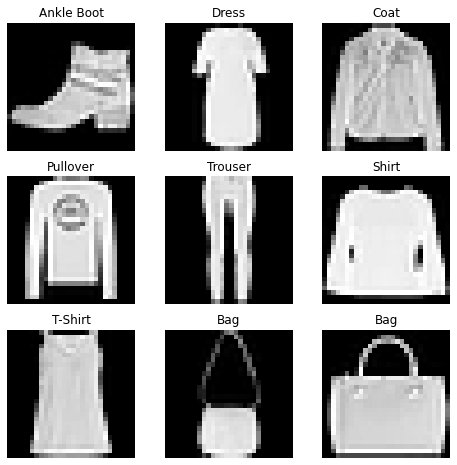

In [5]:
# training_data visualization
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
# showing 3 x 3 grid and adding with picture
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
#     print("sample_id: {}".format(sample_idx))
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
input = torch.randn(20, 16, 50, 100)
print("origin input size: {}".format(input.shape))
# With square kernels and equal stride
m = nn.Conv2d(16, 33, 3, stride=2)
output = m(input)
print("output size: {}".format(output.shape))
# non-square kernels and unequal stride and with padding
m = nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2))
output = m(input)
print("output size: {}".format(output.shape))
# non-square kernels and unequal stride and with padding and dilation
m = nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2), dilation=(3, 1))
output = m(input)
print("output size: {}".format(output.shape))

origin input size: torch.Size([20, 16, 50, 100])
output size: torch.Size([20, 33, 24, 49])
output size: torch.Size([20, 33, 28, 100])
output size: torch.Size([20, 33, 26, 100])


In [7]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [10]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [11]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
print("Done!")

Epoch 1
-------------------------------
loss: 2.306944  [    0/60000]
loss: 2.292522  [ 6400/60000]
loss: 2.285607  [12800/60000]
loss: 2.279470  [19200/60000]
loss: 2.254381  [25600/60000]
loss: 2.270634  [32000/60000]
loss: 2.256348  [38400/60000]
loss: 2.240725  [44800/60000]
loss: 2.257612  [51200/60000]
loss: 2.238885  [57600/60000]
Test Error: 
 Accuracy: 45.6%, Avg loss: 0.034877 

Epoch 2
-------------------------------
loss: 2.238145  [    0/60000]
loss: 2.219609  [ 6400/60000]
loss: 2.200689  [12800/60000]
loss: 2.206854  [19200/60000]
loss: 2.128843  [25600/60000]
loss: 2.182401  [32000/60000]
loss: 2.138747  [38400/60000]
loss: 2.116815  [44800/60000]
loss: 2.165235  [51200/60000]
loss: 2.101400  [57600/60000]
Test Error: 
 Accuracy: 45.7%, Avg loss: 0.032735 

Epoch 3
-------------------------------
loss: 2.129877  [    0/60000]
loss: 2.090638  [ 6400/60000]
loss: 2.060568  [12800/60000]
loss: 2.065911  [19200/60000]
loss: 1.910132  [25600/60000]
loss: 2.033074  [32000/600

In [12]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [13]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [14]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"
